# Projet 3:  Concevez une application au service de la santé publique
--------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------

# P3_Part2 - Exploration des données
--------------------------------------------------------

# 1. Contexte
--------------------------------------

L'idée d'application, avec test de faisabilité, portera sur la similarité d'un produit recherché selon les caractéristiques des produits (energie,...).

La pré-prototype de l'application sera dans un premier temps, un moteur de recommandation : à partir de la recherche d'un produit, la liste des produits les plus sains classés par score (le nombre de g de protéines le plus faible possible, produit le plus sain donc nutri-score le plus bas) sera proposée, après interrogation du jeu de données nettoyés et imputés à partir de la base de données d'Open Food Facts.

**Mission**

----------------------------------------------------------------------------------------------

- Analyse univariée, et bi-variée
- Influence des protéiniques, et label organique sur le nutriscore (ANOVA)
- Exploration ds variables (PCA)
- Clustering (sur la variable 'energy')

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import seaborn as sns
import scipy as sp
from statsmodels.graphics.gofplots import qqplot
import fonctions_data

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='iframe'
from skimage import io

import re
import math

from sklearn import decomposition
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

sns.set()
pd.set_option('display.max_columns', None)

## 1. Chargement du jeu de données

Le jeu de données chargé correspond à la sauvegarde du jeu de données nettoyé lors de la première phase de nettoyage.

In [2]:
# Chargement du jeu de données, séparateur = tabulation d'après la description des variables
data = pd.read_csv('cleaned_data.csv', sep='\t', index_col=0)
data

,url,product_name,image_small_url,main_category_fr,categories_tags,organic,energy_100g,nutrition_score_fr_100g,saturated_fat_100g,sugars_100g,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,fiber_100g,nutrition_grade_fr
0,http://world-fr.openfoodfacts.org/produit/0000...,Salade Cesar,NaN,Légumes frais,"en:plant-based-foods-and-beverages,en:plant-ba...",NaN,0.0,6.0,7.000,0.000,22.000,12.00,23.00,2.16000,2.000,C
1,http://world-fr.openfoodfacts.org/produit/0000...,Chaussons tressés aux pommes,NaN,Pâtisseries,"en:sugary-snacks,en:biscuits-and-cakes,en:past...",NaN,0.0,9.0,2.000,24.700,3.330,10.70,38.70,0.64700,2.000,C
2,http://world-fr.openfoodfacts.org/produit/0000...,Pain Burger Artisan,NaN,Boulange,fr:boulange,NaN,0.0,1.0,0.333,1.110,10.000,1.11,53.30,1.52000,2.220,B
3,http://world-fr.openfoodfacts.org/produit/0000...,Quiche Lorraine,NaN,Plats préparés,"en:meals,en:pizzas-pies-and-quiches,en:quiches...",NaN,0.0,2.0,2.860,0.714,5.360,6.79,7.86,0.49900,0.357,B
4,http://world-fr.openfoodfacts.org/produit/0000...,Belgische Pralinen,NaN,Aliments et boissons à base de végétaux,"en:plant-based-foods-and-beverages,en:plant-ba...",False,0.0,26.0,21.100,51.500,4.700,33.30,53.80,0.09000,0.000,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56493,http://world-fr.openfoodfacts.org/produit/9609...,Santa Cruz Chilli & Lime Dressing,http://fr.openfoodfacts.org/images/products/96...,Epicerie,"en:groceries,en:sauces,en:salad-dressings",False,0.0,6.0,0.500,16.700,0.300,6.90,23.10,0.54102,0.600,C
56494,http://world-fr.openfoodfacts.org/produit/9611...,Fisherman's Friend Miel-Citron,NaN,Bonbons,"en:sugary-snacks,en:confectioneries,en:candies...",False,0.0,2.0,1.280,0.100,0.004,1.30,95.31,0.00100,1.470,B
56495,http://world-fr.openfoodfacts.org/produit/9778...,Nature cheddar and red onion crisps,NaN,Chips et frites,"en:salty-snacks,en:appetizers,en:chips-and-fri...",NaN,0.0,9.0,3.400,1.800,7.800,0.00,0.00,1.35000,5.600,C
56496,http://world-fr.openfoodfacts.org/produit/9847...,Tartines craquantes bio au sarrasin,http://fr.openfoodfacts.org/images/products/98...,Pains,"en:plant-based-foods-and-beverages,en:plant-ba...",True,0.0,-4.0,0.600,2.600,13.000,2.80,74.80,0.68000,5.900,A


## 2. Matrice de corrélation des données et 'pairplot'

### 2.1) Corrélation des variables

On affiche la matrice de corrélations afin de connaitre les relations entre les différentes variables

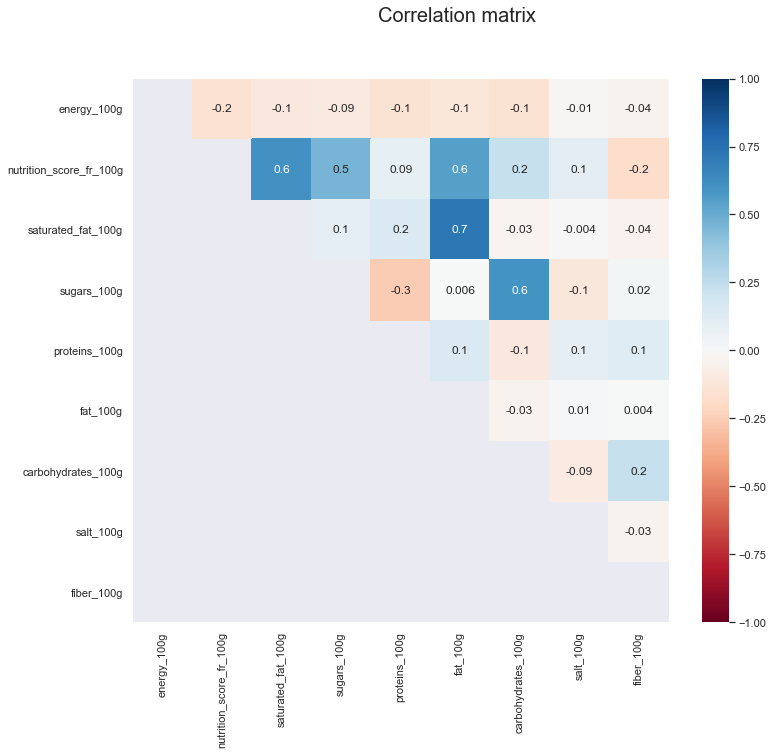

In [3]:
correlation_matrix = data.corr(method='pearson')
triangular_matrix = np.tril(correlation_matrix)

fig, ax = plt.subplots(figsize=(12,10)) 
fig.suptitle("Correlation matrix", fontsize=20)
sns.heatmap(correlation_matrix, annot=True, fmt='.1g', mask=triangular_matrix, vmin=-1, vmax=1, cmap= 'RdBu')
plt.show()

### 2.2) Pairplot sur les données nutritionnelles

C:\Users\yanni\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning:

Dataset has 0 variance; skipping density estimate.



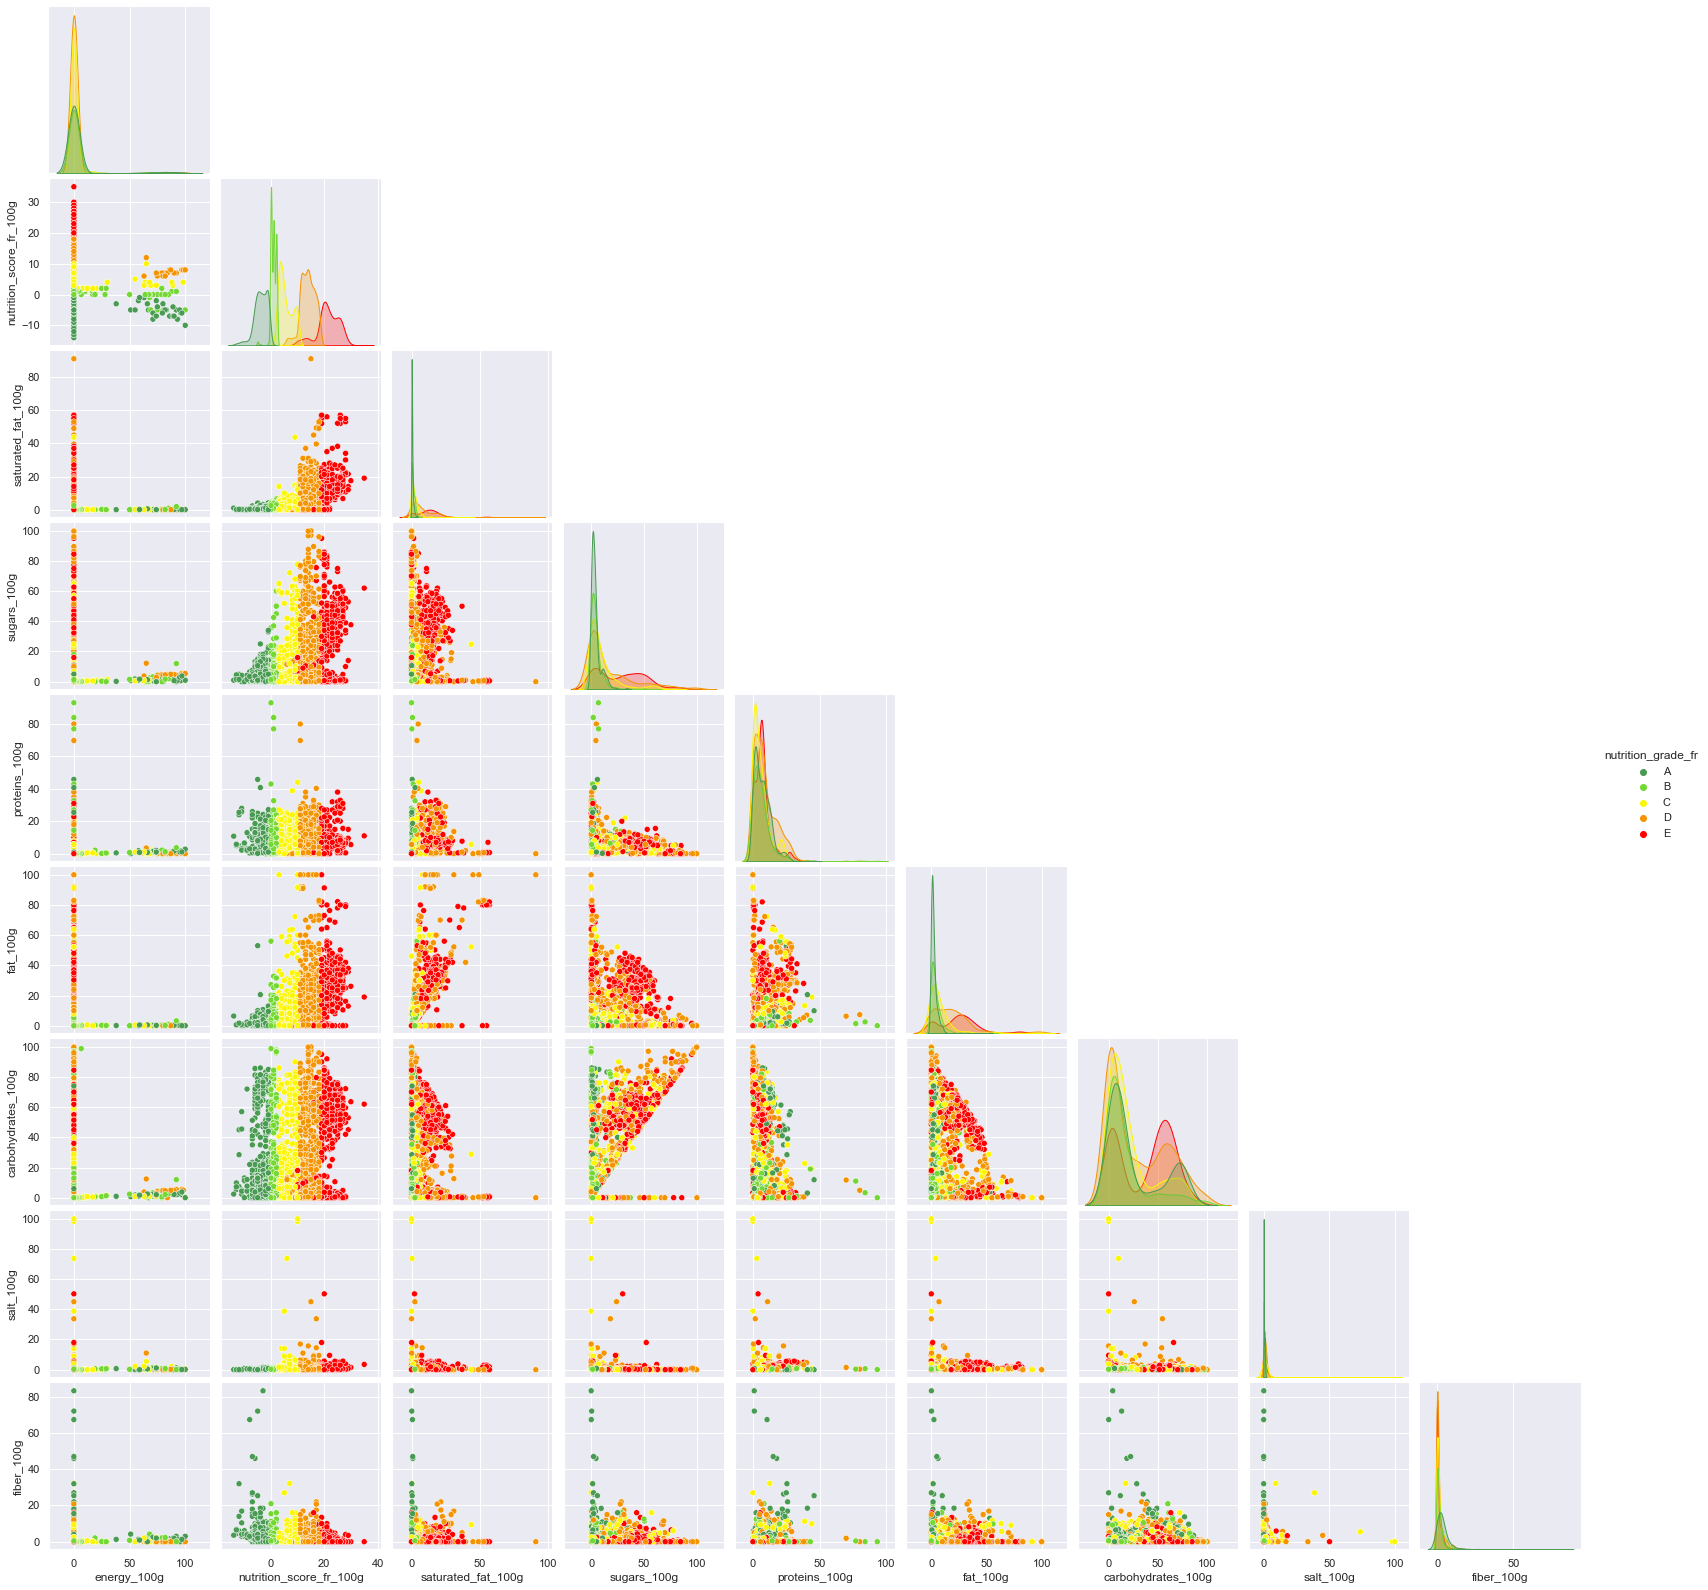

In [34]:
# We plot the pairplot only on a 5% sample of the dataset to make it quicker
colors = ["#499A53", "#74D834", "#FBF605", "#F49402", "#FF0000"]

nutri_columns = [x for x in data.columns.values if x.endswith('_100g')] + ['nutrition_grade_fr']
nutri_data = data[nutri_columns].sample(round(len(data)*0.05))
sns.pairplot(nutri_data, corner=True, hue='nutrition_grade_fr', hue_order=['A', 'B', 'C', 'D', 'E'], palette=colors)
plt.show()

In [3]:
# Statistiques descriptives des variables
fonctions_data.stat_descriptives(data)

,Variable name,Mean,Median,Skew,Kurtosis,Variance,Stdev,min,25%,50%,75%,max
0,energy_100g,1.987819,0.00,6.423144,40.854109,148.253086,12.175922,0.0,0.00,0.00,0.0,100.0
1,nutrition_score_fr_100g,8.350083,8.00,0.182099,-0.910407,82.630336,9.090123,-15.0,1.00,8.00,15.0,40.0
2,saturated_fat_100g,5.291925,1.87,3.263248,17.630671,67.617020,8.222957,0.0,0.20,1.87,7.2,100.0
3,sugars_100g,12.842952,4.00,1.947357,3.497939,339.713675,18.431323,0.0,1.00,4.00,16.0,100.0
4,proteins_100g,7.422809,5.80,1.844327,6.987238,54.728987,7.397904,0.0,1.60,5.80,10.1,93.1
5,fat_100g,12.636447,5.60,2.234466,6.497715,281.457428,16.776693,0.0,0.60,5.60,20.0,100.0
6,carbohydrates_100g,25.941620,12.90,0.786519,-0.811039,729.821426,27.015207,0.0,3.00,12.90,51.0,100.0
7,salt_100g,0.984538,0.50,21.766107,580.670243,11.337130,3.367066,0.0,0.07,0.50,1.2,100.0
8,fiber_100g,1.695777,0.10,6.064252,76.899330,11.121771,3.334932,0.0,0.00,0.10,2.3,87.5


In [4]:
# Nom des colonnes
data.columns.to_list()

['url',
 'product_name',
 'image_small_url',
 'main_category_fr',
 'categories_tags',
 'organic',
 'energy_100g',
 'nutrition_score_fr_100g',
 'saturated_fat_100g',
 'sugars_100g',
 'proteins_100g',
 'fat_100g',
 'carbohydrates_100g',
 'salt_100g',
 'fiber_100g',
 'nutrition_grade_fr']

In [5]:
# Transformation des variables catégoriques
data['organic'] = data['organic'].astype('category')
data['nutrition_grade_fr'] = data['nutrition_grade_fr'].astype('category')

-------------------------------------------------------------
Type de variable pour chacune des variables



url                          object
product_name                 object
image_small_url              object
main_category_fr             object
categories_tags              object
organic                    category
energy_100g                 float64
nutrition_score_fr_100g     float64
saturated_fat_100g          float64
sugars_100g                 float64
proteins_100g               float64
fat_100g                    float64
carbohydrates_100g          float64
salt_100g                   float64
fiber_100g                  float64
nutrition_grade_fr         category
dtype: object

,Nombre par type de variable,% des types de variable
float64,9,56.250000
object,5,31.250000
category,1,6.250000
category,1,6.250000


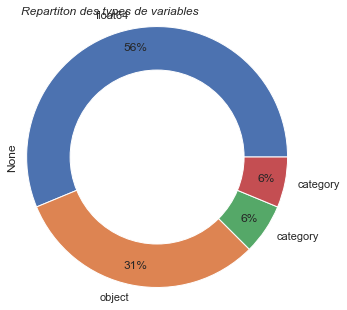

In [6]:
# Types de variables
fonctions_data.affichage_types_var(data, True, True, True)

## 3) Analyse univariée et bivariée

### 3.1) Variables quantitatives discrètes

**Nutri-score**

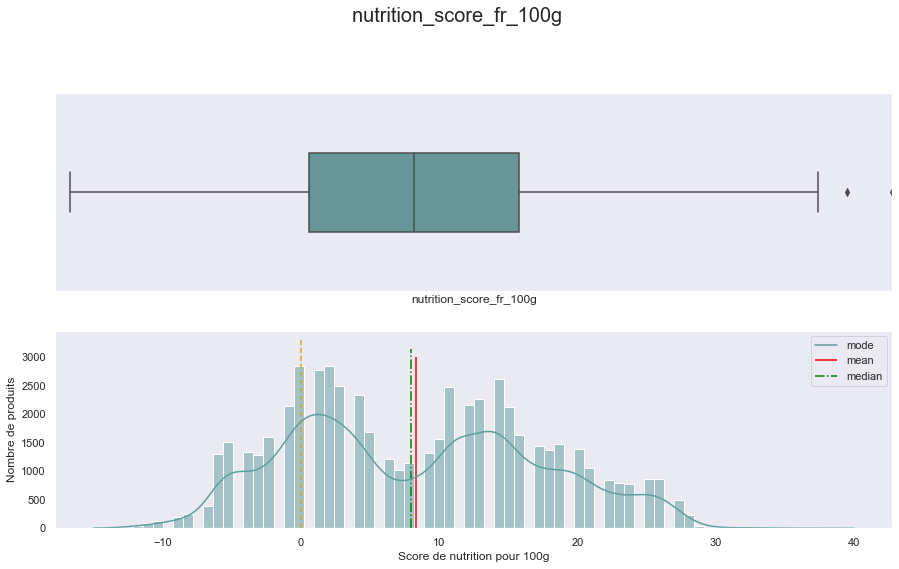

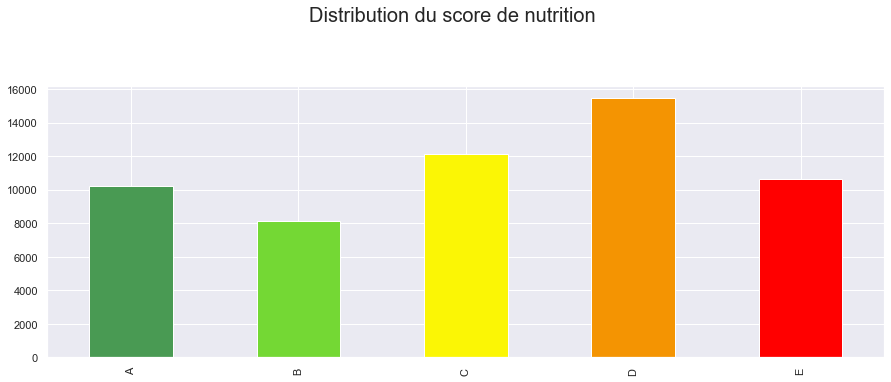

A    10216
B     8099
C    12133
D    15435
E    10615
Name: nutrition_grade_fr, dtype: int64

In [30]:
colors = ["#499A53", "#74D834", "#FBF605", "#F49402", "#FF0000"]

# Protéines
fonctions_data.trace_histplot(data, 'nutrition_score_fr_100g','cadetblue', 'nutrition_score_fr_100g ',
                                    'Score de nutrition pour 100g',
                                    -16, 40, -1, 1)

fig = plt.figure(figsize=(15, 5))
fig.suptitle('Distribution du score de nutrition', fontsize=20, y=1.1)
nutriscore_grade_data = data['nutrition_grade_fr'].value_counts().sort_index()
#axes[0][1].set_title("Distribution of nutrition grades", fontsize=16, pad=25)
nutriscore_grade_data.plot(kind="bar", color=colors)
plt.show()

nutriscore_grade_data


In [9]:
# Statistiques descriptives
cols = data.select_dtypes(include=[np.number]).columns.to_list()
d = fonctions_data.stat_descriptives(data[cols])
d[d['Variable name']=='nutrition_score_fr_100g'].T

,1
Variable name,nutrition_score_fr_100g
Mean,8.350083
Median,8.0
Skew,0.182099
Kurtosis,-0.910407
Variance,82.630336
Stdev,9.090123
min,-15.0
25%,1.0
50%,8.0


In [10]:
SAMPLE_PERCENTAGE = 10
data_sample = data.sample(round(len(data)*SAMPLE_PERCENTAGE/100))
data_sample.columns
#fonctions_data.get_nutri_col(data_sample, cols_suppr=['nutrition_score_fr_100g'])

Index(['url', 'product_name', 'image_small_url', 'main_category_fr',
       'categories_tags', 'organic', 'energy_100g', 'nutrition_score_fr_100g',
       'saturated_fat_100g', 'sugars_100g', 'proteins_100g', 'fat_100g',
       'carbohydrates_100g', 'salt_100g', 'fiber_100g', 'nutrition_grade_fr'],
      dtype='object')

**Evolution du nutriscore selon les autres données nutritionnelles**

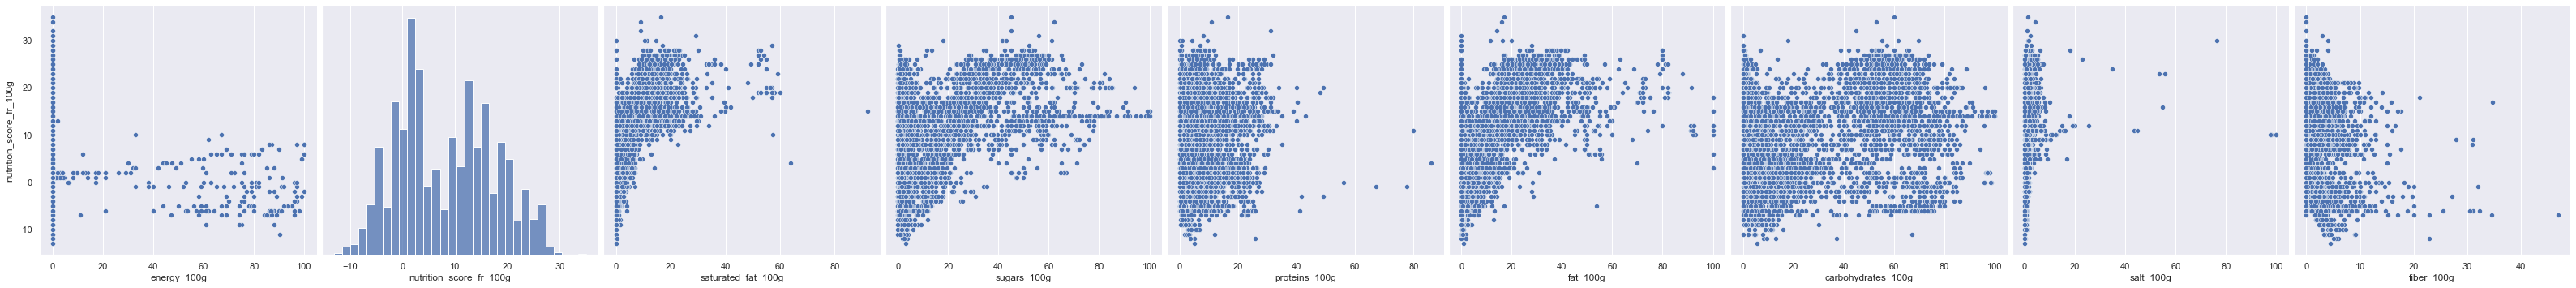

In [43]:
# Working on a sample dataset to make it quicker
SAMPLE_PERCENTAGE = 10
data_sample = data.sample(round(len(data)*SAMPLE_PERCENTAGE/100))
data_sample.columns
sns.pairplot(data_sample, 
             x_vars=fonctions_data.get_nutri_col(data_sample),
             y_vars=["nutrition_score_fr_100g"],
             height=5)
plt.show()

**Energie pour 100g**

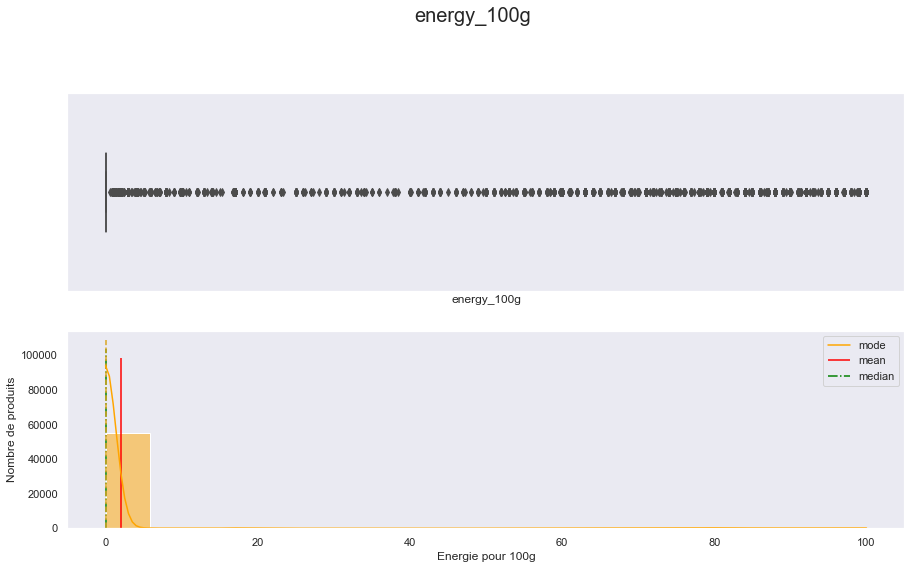

In [27]:
# Energy 100g
fonctions_data.trace_histplot(data, 'energy_100g', 'orange' ,'energy_100g',
                                    'Energie pour 100g',
                                    -5, 105, -1, 1)

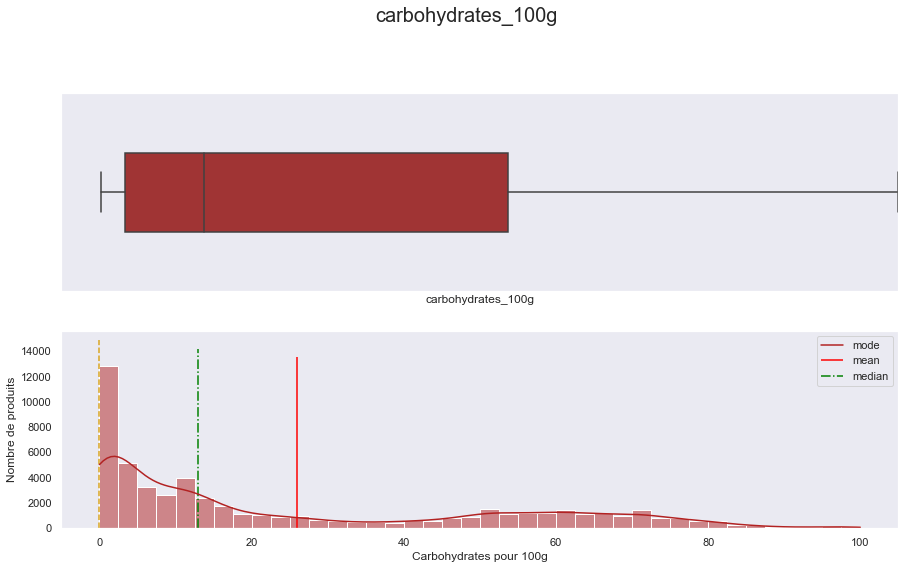

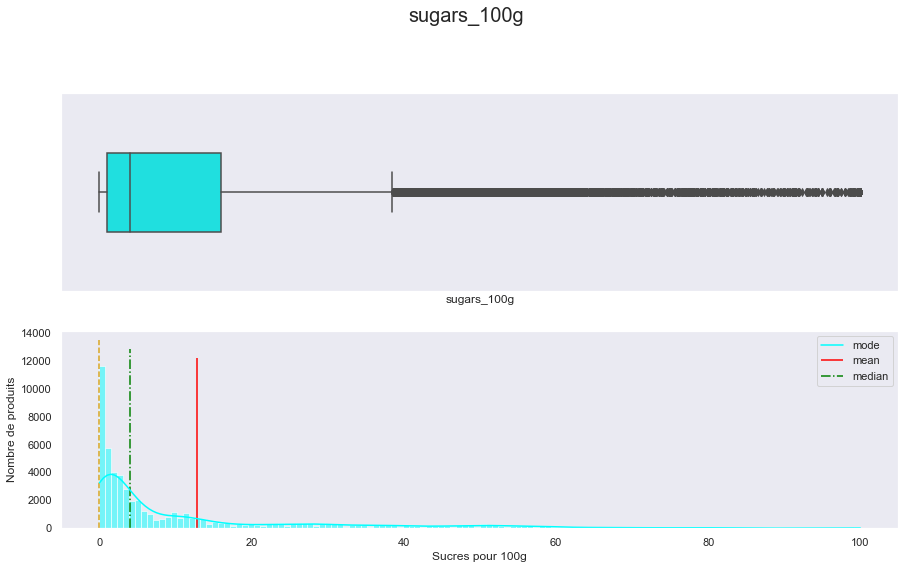

In [28]:
# Carbohydrates pour 100g 
fonctions_data.trace_histplot(data, 'carbohydrates_100g','firebrick', 'carbohydrates_100g',
                                    'Carbohydrates pour 100g',
                                    -5, 100, -1, 1)

# Sucres pour 100g 
fonctions_data.trace_histplot(data, 'sugars_100g', 'cyan', 'sugars_100g',
                                    'Sucres pour 100g',
                                    -5, 105, -1, 1)

In [15]:
# Statistiques descriptives
d = fonctions_data.stat_descriptives(data[cols])
d[d['Variable name'].str.contains('carbohydrates|sugars')].T

,3,6
Variable name,sugars_100g,carbohydrates_100g
Mean,12.842952,25.94162
Median,4.0,12.9
Skew,1.947357,0.786519
Kurtosis,3.497939,-0.811039
Variance,339.713675,729.821426
Stdev,18.431323,27.015207
min,0.0,0.0
25%,1.0,3.0
50%,4.0,12.9


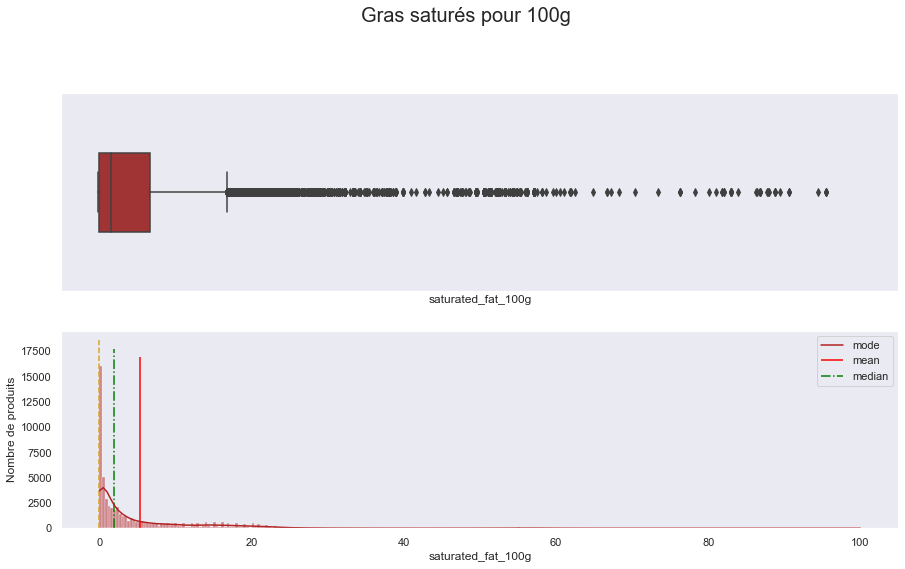

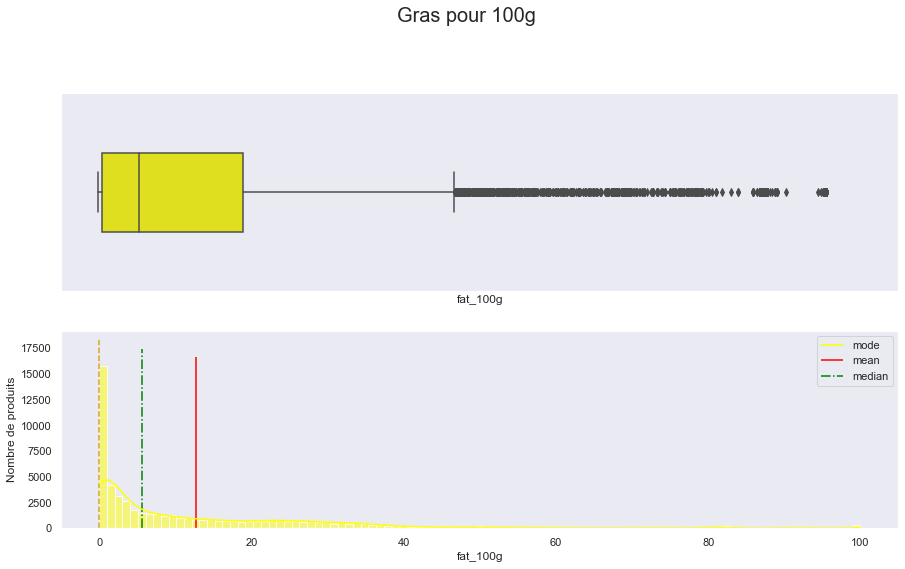

In [16]:
#Gras saturés pour 100g 
fonctions_data.trace_histplot(data, 'saturated_fat_100g','firebrick', 'Gras saturés pour 100g',
                                    'saturated_fat_100g',
                                    -5, 110, -1, 1)

#Gras pour 100g 
fonctions_data.trace_histplot(data, 'fat_100g', 'yellow', 'Gras pour 100g',
                                    'fat_100g',
                                    -5, 110, -1, 1)

In [48]:
# Statistiques descriptives
d = fonctions_data.stat_descriptives(data[cols])
d[d['Variable name'].str.contains('saturated_fat|fat')].T

,2,5
Variable name,saturated_fat_100g,fat_100g
Mean,5.291925,12.636447
Median,1.87,5.6
Skew,3.263248,2.234466
Kurtosis,17.630671,6.497715
Variance,67.61702,281.457428
Stdev,8.222957,16.776693
min,0.0,0.0
25%,0.2,0.6
50%,1.87,5.6


Bilan:

Toutes les courbes des variables quantitatives continues sont asymétriques, avec un skewness positif, indiquant une distribution étalée à droite.
Les courbes sont moins aplaties que la distribution normale donc les observations sont plus concentrées d'après les kurtosis empiriques positifs. Exception pour la courbe des glucides, avec un kurtosos empirique négatif donc une distribution plus aplatie que la distribution normale.
Un pic autour de 0 pour toutes les variables quantitatives ne peuvent pas être imputées à des valeurs erronées, puisque certains produits ne contiennent ni lipides, ni glucides, ni protéines, ni sel...

**Nutrigrades par catégories de nutriments**

In [49]:
colors = ["#499A53", "#74D834", "#FBF605", "#F49402", "#FF0000"]

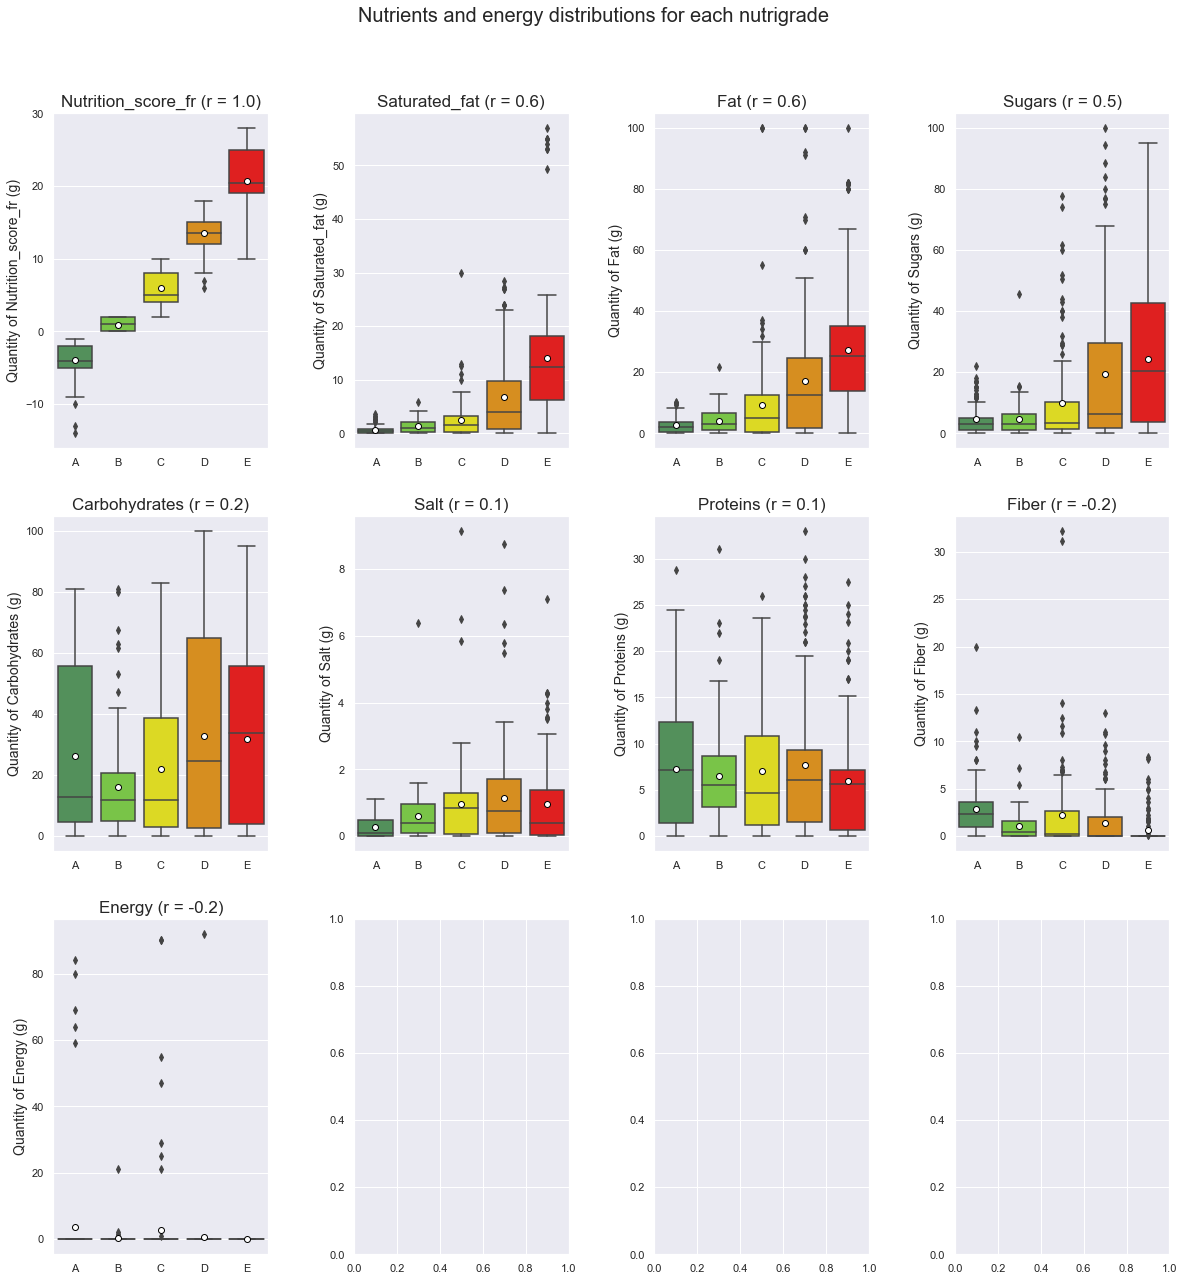

In [50]:
# Working on a data sample
colors = ["#499A53", "#74D834", "#FBF605", "#F49402", "#FF0000"]
nutritional_columns = fonctions_data.get_nutri_col(data, cols_suppr='')+['nutrition_grade_fr']
data_sample = data[nutritional_columns].sample(round(len(data)*0.01))

# Sorting columns by Pearson desc
pearsons = []
for column in nutritional_columns:
    if column in correlation_matrix['nutrition_score_fr_100g']:
        pearson = round(correlation_matrix['nutrition_score_fr_100g'].loc[column],1)
    else:
        pearson = 0.0
    pearsons.append(pearson)
nutritional_columns = [x for _, x in sorted(zip(pearsons, nutritional_columns), reverse=True)]

# Calculating number of rows and cols to display it cleanly
MAX_COLS = 4
if len(nutritional_columns)-1 <= MAX_COLS:
    nrows = 1
    ncols = len(nutritional_columns)-1
else:
    nrows = math.ceil((len(nutritional_columns)-1) / MAX_COLS)
    ncols = MAX_COLS

# Preparing figure
fig, axes = plt.subplots(figsize=(20,nrows*7), nrows=nrows, ncols=ncols)
fig.subplots_adjust(hspace=0.2, wspace=0.4)
fig.suptitle("Nutrients and energy distributions for each nutrigrade", fontsize=20, y=0.95)

# Ploting each boxplot
nutritional_columns.remove("nutrition_grade_fr")
for index, column in enumerate(nutritional_columns):
    row_index = math.floor(index / MAX_COLS)
    col_index = index % MAX_COLS

    # We retrieve the pearson coefficient between nutriscore and the column to display it
    pearson = round(correlation_matrix['nutrition_score_fr_100g'].loc[column],1)

    column_title = column.replace('_100g', '').replace('-kcal', '').capitalize()
    sns.boxplot(x=data_sample["nutrition_grade_fr"], 
                y=data_sample[column], 
                ax=axes[row_index][col_index], 
                palette=colors, 
                order=['A', 'B', 'C', 'D', 'E'],
                showmeans=True,
                meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"6"})
    axes[row_index][col_index].set_title(column_title + " (r = " + str(pearson) + ")", fontsize=17)
    axes[row_index][col_index].set_xlabel("")

    y_label = "Quantity of " + column_title
    if 'kcal' not in column:
        y_label += " (g)"
    else:
        y_label += " (kcal)"
    axes[row_index][col_index].set_ylabel(y_label, fontsize=14)

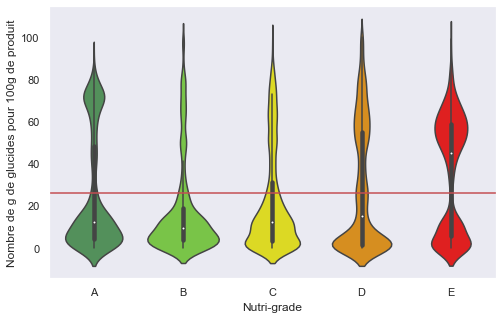

In [51]:
plt.figure(figsize=[8, 5])

# Violinplot glucides/nutri-score grade
sns.violinplot(data=data, x='nutrition_grade_fr', y='carbohydrates_100g',
               palette=colors, order='ABCDE')
plt.ylabel('Nombre de g de glucides pour 100g de produit', fontsize=12)
plt.xlabel('Nutri-grade', fontsize=12)
plt.grid(False)
# Ajout moyenne des glucides pour tous les produits
moyenne_glucides = data['carbohydrates_100g'].mean()
plt.axhline(y=moyenne_glucides, color='r')

plt.show()

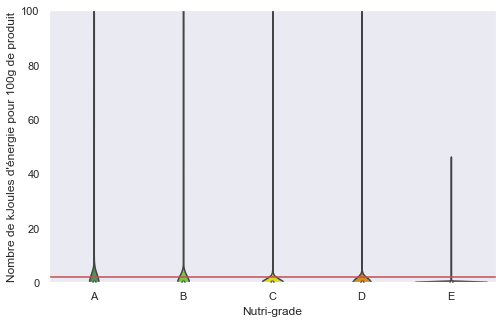

In [55]:
plt.figure(figsize=[8, 5])

# Violinplot énergies nutritionnelles/nutri-score grade
ax = sns.violinplot(data=data, x='nutrition_grade_fr', y='energy_100g',
               palette=colors, order='ABCDE')
#ax.set_xlim(xlim_bas, xlim_haut)
ax.set_ylim(0, 100)
plt.ylabel('Nombre de kJoules d\'énergie pour 100g de produit', fontsize=12)
plt.xlabel('Nutri-grade', fontsize=12)
plt.grid(False)
# Ajout moyenne des énergies nutritionnelles pour tous les produits
moyenne_energie = data['energy_100g'].mean()
plt.axhline(y=moyenne_energie, color='r')

plt.show()

**Bilan:**

- **Lipides/ acides gras saturés :** plus le produit contient des lipides ou des acides gras saturés, plus le produit à un nutri-score élevé et est donc mal noté.
- **Glucides/Sucres :** plus le produit contient du sucre, plus le produit à un nutri-score élevé et est donc mal noté. Mais la répartition des glucides (sûrement les glucoses, fructoses (dommage de ne pas avoir assez d'informations sur la répartition des glucides)) est différente puisque certains produits contenant plus de 60g de sucre sont notés A donc très bien notés.
- **Fibres :** les produits contenant des fibres sont les mieux notés.
- **Protéines :** voir l'analyse dans le zoom ci-dessous.
- **Additifs :** plus le produit contient des additifs, plus il est mal noté.
- **Nutri-score :** très peu de produits sont bien notés (conforme à l'analyse précédente du nutri-score grade).
- **Sel :** plus le produit contient du sel, plus il est mal noté.
- **Energie :** plus le produit est mal noté, plus le produit est calorique, à l'exception de produits qui sont caloriques mais noté A.
- Le bilan par nutriments est conforme à la définition et la répartition du nutri-score donné par Santé Publique France.

**Zoom - répartition protéines / nutri-grade**

Hypothèse à vérifier : d'après la définition du nutri-score, on s'attend à ce que les produits les plus protéinés ont les scores les plus bas donc un nutri-grade A ou B?

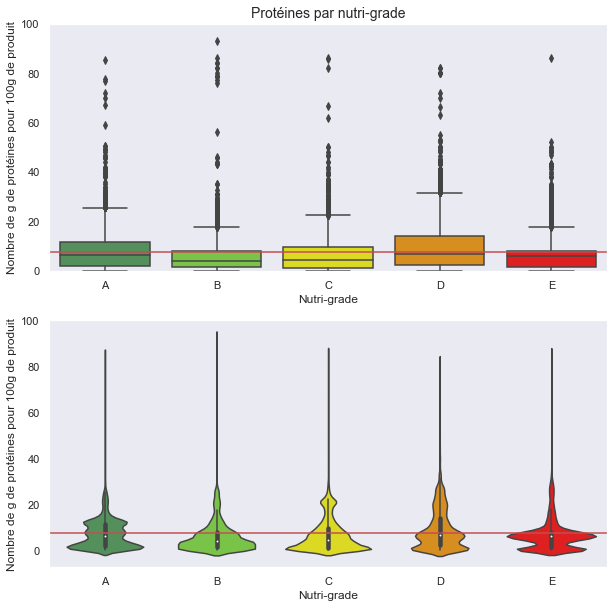

In [56]:
plt.figure(figsize=[10, 10])

# Boxplot protéines/nutri-score grade
plt.subplot(2, 1, 1)
sns.boxplot(data=data, x='nutrition_grade_fr', y='proteins_100g',
            palette=colors, order='ABCDE')
plt.ylim(0, 100)
plt.ylabel('Nombre de g de protéines pour 100g de produit', fontsize=12)
plt.xlabel('Nutri-grade', fontsize=12)
plt.title('Protéines par nutri-grade', fontsize=14)
plt.grid(False)
# Ajout moyenne des protéines pour tous les produits
moyenne_proteines = data['proteins_100g'].mean()
plt.axhline(y=moyenne_proteines, color='r')

# Violinplot protéines/nutri-score grade
plt.subplot(2, 1, 2)
sns.violinplot(data=data, x='nutrition_grade_fr', y='proteins_100g',
               palette=colors, order='ABCDE')
plt.ylabel('Nombre de g de protéines pour 100g de produit', fontsize=12)
plt.xlabel('Nutri-grade', fontsize=12)
plt.grid(False)
# Ajout moyenne des protéines pour tous les produits
plt.axhline(y=moyenne_proteines, color='r')

plt.show()

C:\Users\yanni\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



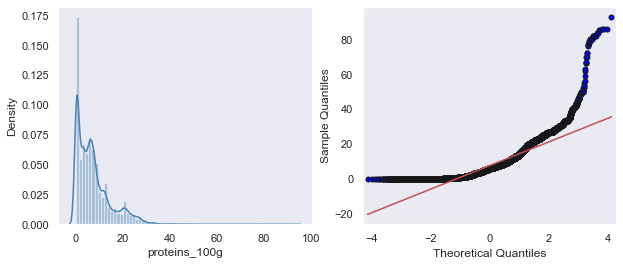

In [22]:
fig = plt.figure(figsize=[10, 4])

# Distplot protéines
ax1 = fig.add_subplot(1, 2, 1)
sns.distplot(data['proteins_100g'], bins=70, color='SteelBlue', ax=ax1)
plt.grid(False)

# Qqplot protéines
ax2 = fig.add_subplot(1, 2, 2)
qqplot(data['proteins_100g'], line='r', **{'markersize': 5,
                                           'mec': 'k',
                                           'color': 'SteelBlue'}, ax=ax2)
plt.grid(False)

plt.show()

In [14]:
# Préparation des variables de travail pour les graphiques et les tests
gb = data.groupby('nutrition_grade_fr')['proteins_100g']
nutrigr_df = pd.DataFrame([gb.get_group(n).values for n in list('ABCDE')],
                          index=list('ABCDE')).T
nutrigr_df_sans_nan = nutrigr_df.dropna()
nutrigr_df_a = nutrigr_df_sans_nan['A']
nutrigr_df_b = nutrigr_df_sans_nan['B']
nutrigr_df_c = nutrigr_df_sans_nan['C']
nutrigr_df_d = nutrigr_df_sans_nan['D']
nutrigr_df_e = nutrigr_df_sans_nan['E']

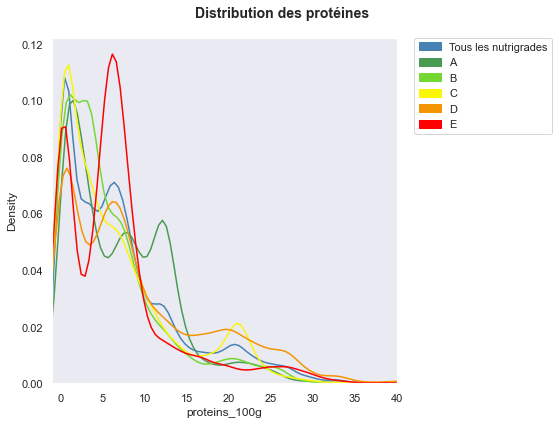

In [59]:
nutrigr_df_a  # Distribution des protéines par nutri-score
fig = plt.figure(figsize=(8, 6))
label_patches = []

sns.kdeplot(data['proteins_100g'], color='SteelBlue')
label_patch = mpatches.Patch(
    color='SteelBlue',
    label='Tous les nutrigrades')
label_patches.append(label_patch)
plt.grid(False)
plt.xlim([-1, 40])

i = 1
for n, c in zip(list('ABCDE'), colors):
    i += 1
    sns.kdeplot(nutrigr_df[n], color=c)
    label_patch = mpatches.Patch(
        color=c,
        label=n)
    label_patches.append(label_patch)
    plt.grid(False)
    plt.xlim([-1, 40])

fig.suptitle('Distribution des protéines',
             fontweight='bold', fontsize=14)
plt.legend(
    handles=label_patches,
    bbox_to_anchor=(
        1.05,
        1),
    loc=2,
    borderaxespad=0.,
    facecolor='white')

plt.tight_layout()
plt.grid(False)
plt.show()

C:\Users\yanni\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\yanni\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\yanni\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\yanni\anaconda3\lib\site-pac

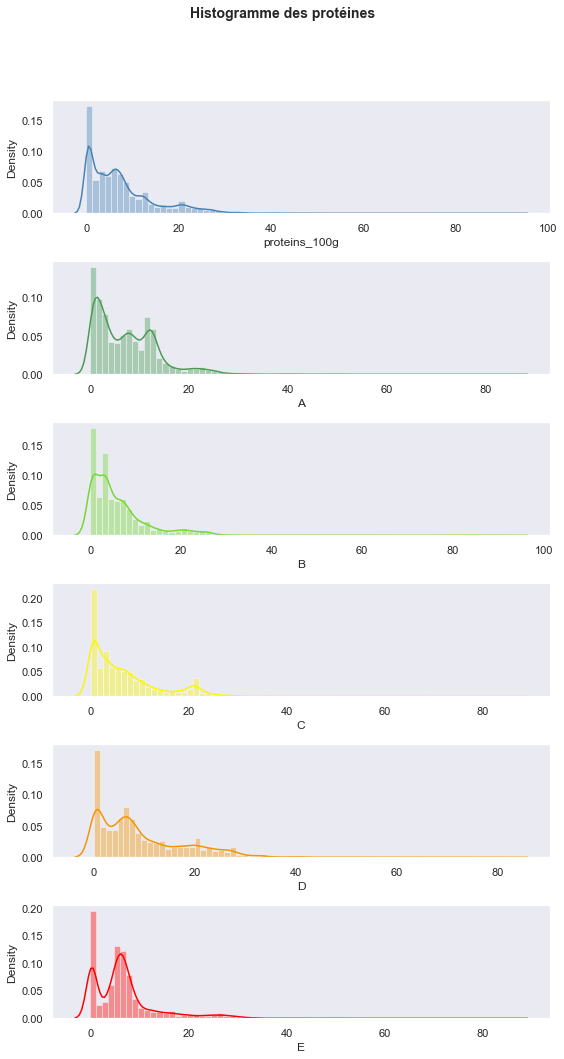

In [60]:
# Histogramme des protéines, général et par nutri-score
fig = plt.figure(figsize=(8, 15))

fig.add_subplot(6, 1, 1)
sns.distplot(data['proteins_100g'], bins=70, color='SteelBlue')
plt.grid(False)

i = 1
for n, c in zip(list('ABCDE'), colors):
    i += 1
    ax = fig.add_subplot(6, 1, i)
    sns.distplot(nutrigr_df[n], color=c, bins=70)
    plt.grid(False)
fig.suptitle('Histogramme des protéines',
             fontweight='bold', fontsize=14)

plt.tight_layout(rect=[0, 0.0, 1, 0.93])
plt.grid(False)
plt.show()

In [62]:
# Statistiques descriptives
d = fonctions_data.stat_descriptives(data[cols])
d[d['Variable name'].str.contains('proteins')].T

,4
Variable name,proteins_100g
Mean,7.422809
Median,5.8
Skew,1.844327
Kurtosis,6.987238
Variance,54.728987
Stdev,7.397904
min,0.0
25%,1.6
50%,5.8


**Bilan:**

______________________________________________________________________

- L'ensemble des des courbes de distribution sont étalées à droite (skewness positif) et moins applatie que la distribution normale, avec des observations plus concentrées (kurtosis empirique positif).
- L'amplitude est comprise entre 0 et 100g de protéines mais 75% des produits contiennent moins de 13g de protéines avec une moyenne de 9g.
- Les différentes courbes de répartition des protéines par nutri-score ne permettent pas de conclure sur les produits bien notés selon leur nombre de grammes de protéines. La variable protéine semble peu corrélée avec le nutri-score.
- La **distribution** ne semble pas **normale** ==> cette hypothèse sera confirmée par un **test de normalité**.
- Le bilan n'est pas conforme à la définition du nutri-score dont le score est favorisé par :

>../..en nutriments et aliments à favoriser (fibres, protéines, fruits, légumes, légumineuses,  huiles de noix et d’olive),../..

- On retrouve dans toutes les plages de g de protéines, toutes les notes de nutri-score ==> nous vérifierons la **variance des moyennes des groupes de protéines par nutri-score** en effectuant un **test ANOVA**.

## 4) Influence de la variable des protéines, et label organique sur le nutriscore (ANOVA)

### 4.1) Analyse de la variance des moyennes des protéines sur  le nutriscore

L'analyse de la variance est une méthode statistique utilisée pour vérifier les moyennes de deux ou plusieurs groupes qui sont significativement différents les uns des autres.

L'ANOVA à sens unique teste la relation entre le prédicteur catégorique et la réponse continue.

Nous vérifierons ici s'il y a une variance égale entre les groupes de caractéristiques catégorielles 'nutrition_grade_fr' et la réponse continue 'proteins_100g'. S'il y a une variance égale entre les groupes, cela signifie que cette caractéristique n'a pas d'impact sur la réponse et qu'elle ne peut pas être prise en compte pour la formation du modèle.

**Hypohèses ANOVA**

___________________________________________________________________________

- (H0): les moyennes des protéines par nutriscore sont égales (moy(A) = moy(B) = moy(C) = moy(D) = moy(E)).
- (H1): hypothèse alternative : au moins un des groupes de protéines par nutri-score à une moyenne différente des autres groupes (moy(A) != moy(B) != moy(C) != moy(D) != moy(E)).


**Conditions**

______________________________________________________________

Avant d'effectuer le test, on doit vérifier que:

- 1 - Les échantillons sont indépendants les uns des autres.
- 2 - Les données sont normalement distribuées.
- 3 - Les écarts-types de population des groupes sont homoscédastiques.

**ANOVA - Etape 2**

- 1 - Les échantillons sont indépendants les uns des autres: on considère que le jeu de données contient des échantillons indépendants (pas vraiment de test paramétrique).

- 2 - Les données sont normalement distribuées.

**Test de normalité de la distribution : Shapiro-Wilk test**

- Hypothèse (H0): distribution gaussienne

In [41]:
data_anova = data[['proteins_100g', 'nutrition_grade_fr']].dropna(how="any")
stat, p = sp.stats.shapiro(data_anova['proteins_100g'].sample(5000))
print('Produits protéiniques : shapiro=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Les données protéiniques pour la catégorie de nutriscores suit une distribution Gaussienne')
else:
    print('Les données protéiniques pour la catégorie de nutriscores NE suit pas une distribution Gaussienne')    

Produits protéiniques : shapiro=0.840, p=0.000
Les données protéiniques pour la catégorie de nutriscores NE suit pas une distribution Gaussienne


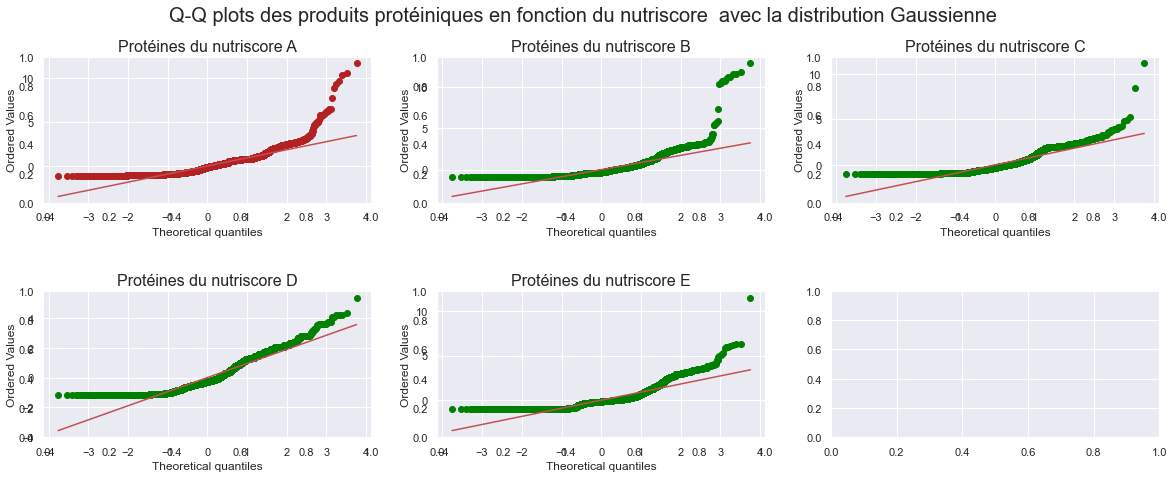

In [47]:
import scipy as sp
fig, axes = plt.subplots(figsize=(20,7), nrows =2 , ncols=3)
fig.suptitle("Q-Q plots des produits protéiniques en fonction du nutriscore  avec la distribution Gaussienne", fontsize=20)

# Valeurs centrées, réduites des qqplots
nutrition_score_a_qq = ((nutrigr_df_a- nutrigr_df_a.mean())/nutrigr_df_a.std()).squeeze()
nutrition_score_b_qq = ((nutrigr_df_b- nutrigr_df_b.mean())/nutrigr_df_b.std()).squeeze()
nutrition_score_c_qq = ((nutrigr_df_c- nutrigr_df_c.mean())/nutrigr_df_c.std()).squeeze()
nutrition_score_d_qq = ((nutrigr_df_d- nutrigr_df_d.mean())/nutrigr_df_d.std()).squeeze()
nutrition_score_e_qq = ((nutrigr_df_e- nutrigr_df_e.mean())/nutrigr_df_e.std()).squeeze()

ax = fig.add_subplot(231)
sp.stats.probplot(nutrition_score_a_qq, dist="norm", plot=plt)
ax.get_lines()[0].set_markerfacecolor('firebrick')
ax.get_lines()[0].set_markeredgecolor('firebrick')
ax.set_title("Protéines du nutriscore A", fontsize=16)

ax = fig.add_subplot(232)
sp.stats.probplot(nutrition_score_b_qq, dist="norm", plot=plt)
ax.get_lines()[0].set_markerfacecolor('green')
ax.get_lines()[0].set_markeredgecolor('green')
ax.set_title("Protéines du nutriscore B", fontsize=16)

ax = fig.add_subplot(233)
sp.stats.probplot(nutrition_score_c_qq, dist="norm", plot=plt)
ax.get_lines()[0].set_markerfacecolor('green')
ax.get_lines()[0].set_markeredgecolor('green')
ax.set_title("Protéines du nutriscore C", fontsize=16)

ax = fig.add_subplot(234)
sp.stats.probplot(nutrition_score_d_qq, dist="norm", plot=plt)
ax.get_lines()[0].set_markerfacecolor('green')
ax.get_lines()[0].set_markeredgecolor('green')
ax.set_title("Protéines du nutriscore D", fontsize=16)

ax = fig.add_subplot(235)
sp.stats.probplot(nutrition_score_e_qq, dist="norm", plot=plt)
ax.get_lines()[0].set_markerfacecolor('green')
ax.get_lines()[0].set_markeredgecolor('green')
ax.set_title("Protéines du nutriscore E", fontsize=16)
plt.gcf().subplots_adjust(wspace = 0.2, hspace = 0.6)



**Conclusion** : On rejette l'hypothèse H0 : la courbe de distribution des protéines n'est pas normale surtout pour les données de tête et de queue.

**Test de similarité des variances: Test de Levene**

Pour les test de similarité de variances, on peut utiliser le test de Bartlett, mais le test de Levene est plus précis pour des distributions non gaussiennes. 

- Hyphothèse (H0): les variances sont similaires

In [15]:
print(" Variance des produits protéiniques pour les catégories de nutriscore = " + str(data[['nutrition_grade_fr','proteins_100g']].var()))

print('\n')
stat, p = sp.stats.levene(nutrigr_df_a, nutrigr_df_b, nutrigr_df_c, nutrigr_df_d, nutrigr_df_e)
print('Résultat test de Levene = %.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Les échantillons valident la similarité des variances (H0): homoscédasticité')
else:
    print('Les échantillons ne valident pas la similarité des variances (H0): hétéroscédasticité')

 Variance des produits protéiniques pour les catégories de nutriscore = proteins_100g    54.729956
dtype: float64


Résultat test de Levene = 214.892, p=0.000
Les échantillons ne valident pas la similarité des variances (H0): hétéroscédasticité


**Conclusion** : p_value<0.05 on rejette H0 au profit de H1, les groupes sont hétéroscédastiques. Tout au moins on ne peut pas dire que les variances sont significativement identiques.

**ANOVA à un facteur: réalisation du test de Kruskal-Wallis**

D'après le résultat précédent, on ne peut pas effectuer l'ANOVA, car les distributions ne sont pas gaussiennes, et n'ont pas de variances similaires. Pour vérifier si la variable 'proteins_100g' a un impact ou non sur la variable catégorique nutriscore, on peut utiliser le test de Kruskal-Wallis (test non paramétrique)

In [21]:
# Kruskall-Wallis test

f_val_2, p_val_2 = sp.stats.kruskal(nutrigr_df_a, nutrigr_df_b, nutrigr_df_c, nutrigr_df_d,
                                 nutrigr_df_e)
print(f'Kruskall-Wallis resultats: F={f_val_2}, P_value={p_val_2}\n')
print('La différence médiane/moyenne de la distribution est non représentative.') if p_val_2 > 0.05 else print(
    'La différence médiane/moyenne de la distribution est représentative.')    

Kruskall-Wallis resultats: F=918.2133247339904, P_value=1.8852478358217452e-197

La différence médiane/moyenne de la distribution est représentative.


**Bilan :**

La statistique H = 918.213 et la valeur p = 0, ce qui indique qu'il y a un effet global significatif du groupe nutri-score grade sur les moyennes des protéines. Cependant, nous ne savons pas encore où se situe la différence entre les nutri-score grade. Donc, sur la base de la valeur p, nous pouvons admettre l'hypothèse H0, c'est-à-dire qu'il n'y a pas une différence significative sur les moyennes de protéines en fonction du nutri-score grade.

In [37]:
X = 'nutrition_grade_fr'  # qualitative
Y = 'proteins_100g'  # quantitative


def eta_squared(x, y):
    moyenne_y = y.mean()
    nutris = []
    for nutri in x.unique():
        yi_nutri = y[x == nutri]
        nutris.append({'ni': len(yi_nutri),
                       'moyenne_nutri': yi_nutri.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_nutri']-moyenne_y)**2 for c in nutris])
    return SCE/SCT


eta_squared(data[X], data[Y])
# si eta_squared est proche de 0 alors les moyennes des protéines par
# nutri-score sont toutes égales

0.02233551643570842

**Constat**:
- Faible relation entre la variable protéine et le nutri-score.

### 4.2) Comparaison des distributions des scores de nutrition

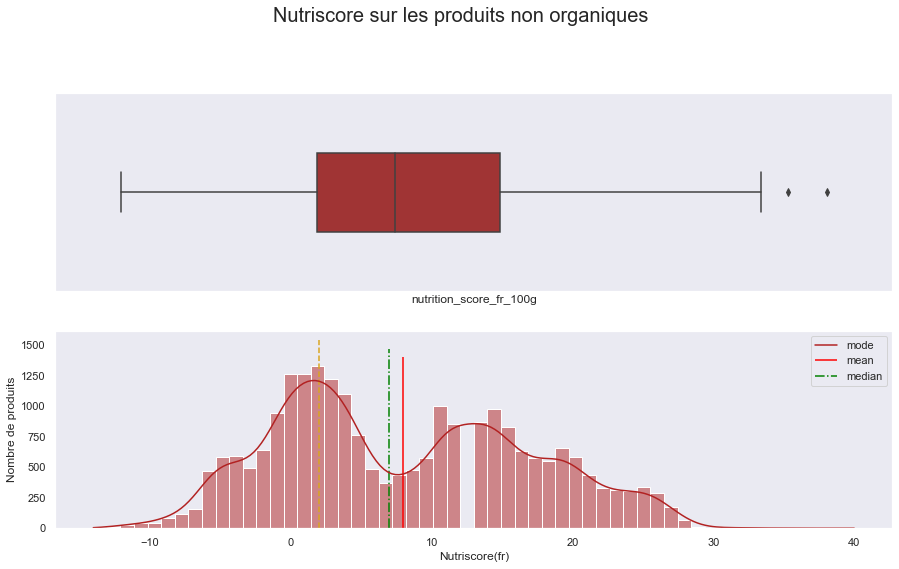

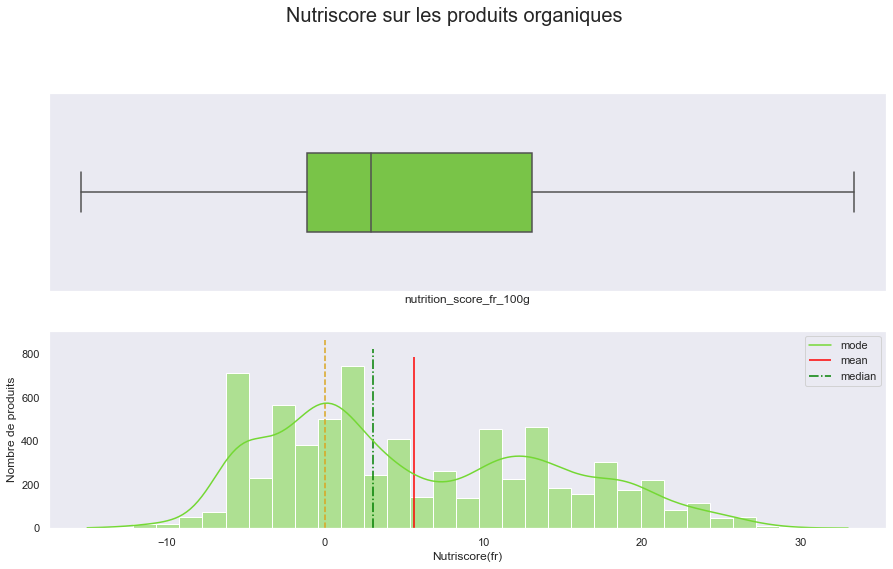

In [12]:
data_anova = data[['organic', 'nutrition_score_fr_100g']].dropna(how="any")
nutrition_score_organic = data_anova[data_anova['organic'] == True]['nutrition_score_fr_100g'].to_frame()
nutrition_score_non_organic = data_anova[data_anova['organic'] == False]['nutrition_score_fr_100g'].to_frame()


fonctions_data.trace_histplot(nutrition_score_non_organic, 'nutrition_score_fr_100g', 'firebrick', 'Nutriscore sur les produits non organiques',
                                    'Nutriscore(fr)', -19, 45, -1, 1)

fonctions_data.trace_histplot(nutrition_score_organic, 'nutrition_score_fr_100g', '#74D834', 'Nutriscore sur les produits organiques',
                                    'Nutriscore(fr)', -17, 35, -1, 1)

Les produits organiques semblent avoir un meilleur score nutritif que les produits non-organiques, en terme de médiane, moyenne(plus proche de -15). En effet, la médiane, ainsi que la moyenne sont à la fois moins élevés que pour celui des produits non-organiques. 
On peut le vérifier à travers le test ANOVA.

**Vérification d'hypothèse ANOVA**

Afin d'effectuer un test ANOVA (en utilisant le test de Fisher), on doit vérifier que nos 2 échantillons sont:

- Indépendantes entre elles: un produit ne peut pas etre à la fois du type organique, et non-organique. 
- Similarité des variances
- Normalité de la distribution

Entre-autres, du fait de la sensibilité de la non-normalité du test de Fisher, ou encore celui de Bartlett, l'alternative sera le test de Levene: plus robuste aux écarts par rapport à l'hypothèse de Normalité.

**Test de normalité de la distribution : Shapiro-Wilk test**

- Hypothèse (H0): distribution gaussienne

In [13]:
stat, p = sp.stats.shapiro(nutrition_score_non_organic.sample(5000))
print('Produits non organiques : shapiro=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Le score de nutrition pour la catégorie organique suit une distribution Gaussienne')
else:
    print('Le score de nutrition pour la catégorie organique NE suit pas une distribution Gaussienne')
    
print("\n")
    
stat, p = sp.stats.shapiro(nutrition_score_organic.sample(5000))
print('Resultat test de Shapiro = %.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Les produits de nutrition non organique suit une distribution Gaussienne')
else:
    print('Les produits de nutrition non organique NE suit pas une distribution Gaussienne')

Produits non organiques : shapiro=0.969, p=0.000
Le score de nutrition pour la catégorie organique NE suit pas une distribution Gaussienne


Resultat test de Shapiro = 0.951, p=0.000
Les produits de nutrition non organique NE suit pas une distribution Gaussienne


Text(0.5, 1.0, 'Produits organiques')

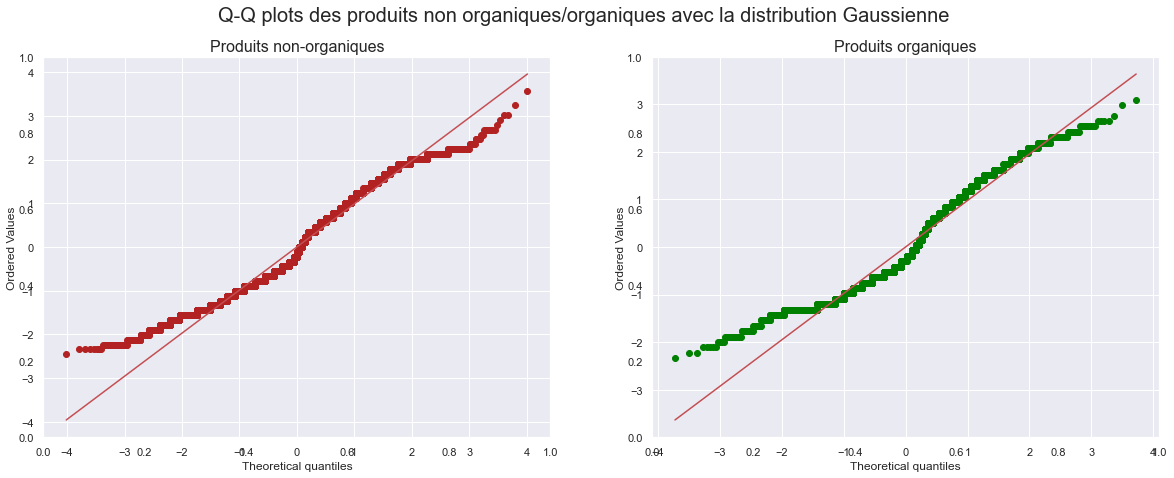

In [68]:
import scipy as sp
fig, axes = plt.subplots(figsize=(20,7), ncols=2)
fig.suptitle("Q-Q plots des produits non organiques/organiques avec la distribution Gaussienne", fontsize=20)

# Valeurs centrées, réduites des qqplots
nutrition_score_non_organic_qq = ((nutrition_score_non_organic - nutrition_score_non_organic.mean())/nutrition_score_non_organic.std()).squeeze()
nutrition_score_organic_qq = ((nutrition_score_organic - nutrition_score_organic.mean())/nutrition_score_organic.std()).squeeze()

ax = fig.add_subplot(121)
sp.stats.probplot(nutrition_score_non_organic_qq, dist="norm", plot=plt)
ax.get_lines()[0].set_markerfacecolor('firebrick')
ax.get_lines()[0].set_markeredgecolor('firebrick')
ax.set_title("Produits non-organiques", fontsize=16)

ax = fig.add_subplot(122)
sp.stats.probplot(nutrition_score_organic_qq, dist="norm", plot=plt)
ax.get_lines()[0].set_markerfacecolor('green')
ax.get_lines()[0].set_markeredgecolor('green')
ax.set_title("Produits organiques", fontsize=16)

**Test de similarité des variances: Test de Levene**

Pour les test de similarité de variances, on peut utiliser le test de Bartlett, mais le test de Levene est plus précis pour des distributions non gaussiennes. 

- Hyphothèse (H0): les variances sont similaires

In [69]:
print("Variance du nutriscore pour les produits non organiques = " + str(nutrition_score_non_organic.var()))
print(" Variance du nutriscore pour les produits organiques = " + str(nutrition_score_organic.var()))

print('\n')
stat, p = sp.stats.levene(nutrition_score_organic.squeeze(), nutrition_score_non_organic.squeeze())
print('Résultat test de Levene = %.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Les échantillons valident la similarité des variances (H0)')
else:
    print('Les échantillons ne valident pas la similarité des variances (H0)')

Variance du nutriscore pour les produits non organiques = nutrition_score_fr_100g    80.288396
dtype: float64
 Variance du nutriscore pour les produits organiques = nutrition_score_fr_100g    78.024506
dtype: float64


Résultat test de Levene = 16.124, p=0.000
Les échantillons ne valident pas la similarité des variances (H0)


**Réalisation du test de Kruskal-Wallis**

D'après le résultat précédent, on ne peut pas effectuer l'ANOVA, car les distributions ne sont pas gaussiennes, et n'ont pas de variances similaires.
Pour vérifier si la variable catégorique 'organic' a un impact ou non sur le score de nutrition, on peut utiliser le test de Kruskal-Wallis (test non paramétrique)

In [70]:
stat, p = sp.stats.kruskal(nutrition_score_non_organic.sample(10000,replace=True), nutrition_score_organic.sample(10000,replace=True))
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('La différence médiane/moyenne de la distribution est non représentative.')
else:
    print('La différence médiane/moyenne de la distribution est représentative.')

stat=379.574, p=0.000
La différence médiane/moyenne de la distribution est représentative.


Les produits organiques ont globalement une meilleure nutrition que celles des non-organiques

## 5) Exploration des variables (ACP)

**Analyse en composantes principales (ACP)**

Le but de cette partie est de réaliser une ACP sur notre jeu de données pour voir si certaines variables peuvent être fusionnées, afin de réduire les colonnes du jeu de données avec les variables présentant les meilleures contributions (part de variance), ou pour définir des catégories de produits.

In [3]:
N_COMP=9

# On garde uniquement les colonnes nutritionnelles et on supprime les lignes ayant un ou plusieurs NA 
colors_nutri = ['#038141', '#85bb2f', '#fecb02', '#ee8100', '#e63e11']
data_dropped = data.copy(deep=True).dropna(how="any")
cols_acp = fonctions_data.get_nutri_col(data)
data_pca = data[cols_acp].dropna(how="any")
feat = data_pca.columns

X = data_pca.values
names = data_dropped["product_name"]
features = data_pca.columns

# On centre et réduit les données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Analyse en composante principale
pca = decomposition.PCA(n_components=N_COMP)
pca.fit(X_scaled)

PCA(n_components=9)

In [4]:
# Valeurs propres ou variances des composantes principales
val_propres = pca.explained_variance_
val_propres

array([2.45128257, 1.79443271, 1.23742317, 1.02380873, 0.91724023,
       0.71300794, 0.38559889, 0.26776475, 0.20960032])

In [5]:
# Vecteurs propres de l'ACP non réduite = combinaison linéaire permettant de
# définir les variables principales
pca.components_.T

array([[-1.83985679e-01,  4.46041482e-02, -4.04211260e-01,
        -3.00449817e-01,  7.45522759e-01, -3.88718552e-01,
        -5.57405922e-02, -2.21054643e-02,  9.70456294e-04],
       [ 5.62603470e-01, -3.30604342e-02, -1.53253879e-01,
         1.60537811e-01,  4.43146809e-02, -1.73905082e-01,
         2.79384436e-01, -2.51044952e-01,  6.78114447e-01],
       [ 5.20758026e-01,  2.47602890e-01, -5.39616258e-02,
        -2.09624116e-01,  8.52195724e-02,  1.16927810e-01,
         1.80695566e-02,  7.70004257e-01, -8.05121528e-02],
       [ 2.92962930e-01, -5.76971444e-01, -1.04480363e-01,
         1.02027922e-01,  4.38148861e-02, -1.55795243e-01,
         4.58836875e-01, -4.33786149e-02, -5.66873837e-01],
       [ 9.12755879e-02,  3.51641804e-01,  5.34426001e-01,
         9.02643207e-02, -5.40010034e-02, -7.36787195e-01,
         3.62586251e-02, -1.29515786e-02, -1.64329244e-01],
       [ 4.94826221e-01,  2.82820463e-01,  5.60803828e-04,
        -2.27744901e-01,  9.50677463e-02,  2.352749

In [6]:
df_acp = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(N_COMP)],
                      columns=cols_acp).T
df_acp

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
energy_100g,-0.183986,0.044604,-0.404211,-0.300450,0.745523,-0.388719,-0.055741,-0.022105,0.000970
nutrition_score_fr_100g,0.562603,-0.033060,-0.153254,0.160538,0.044315,-0.173905,0.279384,-0.251045,0.678114
saturated_fat_100g,0.520758,0.247603,-0.053962,-0.209624,0.085220,0.116928,0.018070,0.770004,-0.080512
sugars_100g,0.292963,-0.576971,-0.104480,0.102028,0.043815,-0.155795,0.458837,-0.043379,-0.566874
proteins_100g,0.091276,0.351642,0.534426,0.090264,-0.054001,-0.736787,0.036259,-0.012952,-0.164329
fat_100g,0.494826,0.282820,0.000561,-0.227745,0.095068,0.235275,-0.335482,-0.563469,-0.358963
carbohydrates_100g,0.194620,-0.583525,0.229731,0.069733,0.106372,-0.154516,-0.701471,0.133618,0.137390
salt_100g,0.016971,0.194394,0.049513,0.821854,0.463835,0.220777,-0.050019,0.056992,-0.119965
fiber_100g,-0.035514,-0.144166,0.677096,-0.298803,0.441178,0.331486,0.315520,-0.054159,0.152333


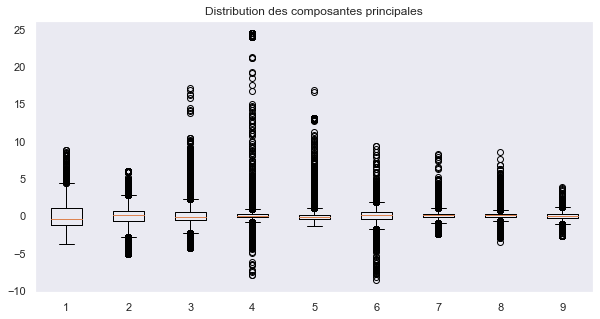

In [7]:
# Composantes principales de l'ACP
C = pca.transform(X_scaled)
plt.figure(figsize=(10, 5))
plt.boxplot(C)
plt.title('Distribution des composantes principales')
plt.grid(False)
plt.show()

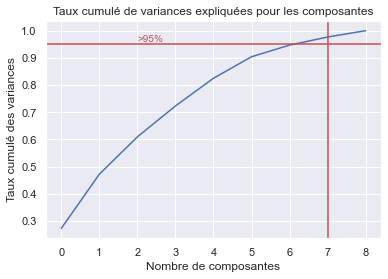

In [8]:
# quel est le pourcentage de variance préservée par chacune de
# nos composantes?
variances = pca.explained_variance_ratio_

# quelle est la somme cumulée de chacune de ces variances?
meilleur_dims = np.cumsum(variances)

#  on va trouver le moment où on attient 95% ou 99% entre réduire au maxi
# où garder au maxi
plt.plot(meilleur_dims)
# argmax pour > 95 %
best = np.argmax(meilleur_dims > 0.95)
plt.axhline(y=0.95, color='r')
plt.text(2, 0.96, '>95%', color='r', fontsize=10)
plt.axvline(x=best, color='r')
plt.title('Taux cumulé de variances expliquées pour les composantes')
plt.xlabel('Nombre de composantes')
plt.ylabel('Taux cumulé des variances')
plt.show()

A partir de la 8ième composante on explique 95% de la variance. On peut dire globalement que l'ensemble des variables apportent une contribution significative.

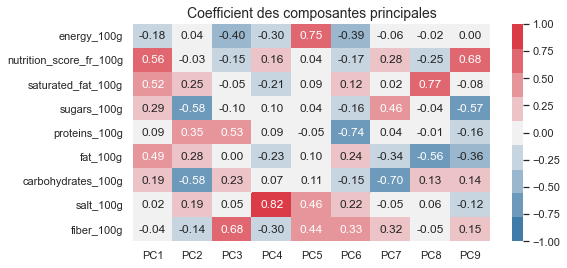

In [9]:
# Matrice des coefficients des composantes principales
fig, ax = plt.subplots(figsize=(8, 4))
palette = sns.diverging_palette(240, 10, n=9)
ax = sns.heatmap(df_acp, annot=True, fmt='.2f',
                 cmap=palette, vmin=-1, vmax=1, center=0)
plt.title('Coefficient des composantes principales', fontsize=14)
plt.show()

#### Affichage du graphique des éboulis des valeurs propres

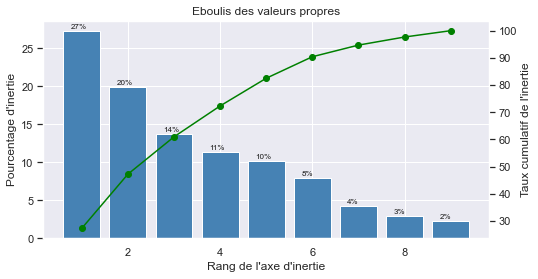

In [22]:
fonctions_data.aff_eboulis_plot(pca)

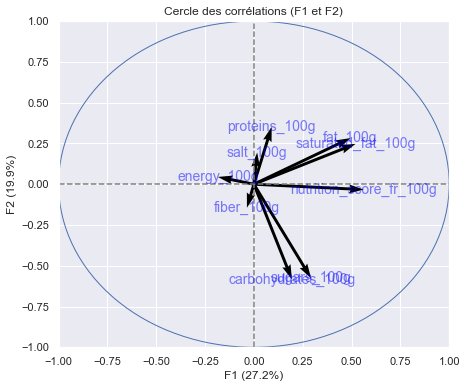

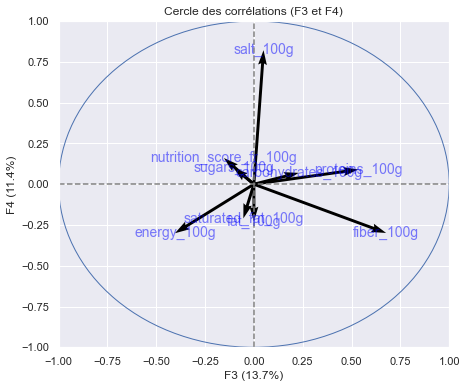

In [11]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd

# Cercle des correlations
pcs = pca.components_
fonctions_data.affiche_cercle(pcs, N_COMP, pca, [(0, 1), (2, 3)], labels=np.array(feat), label_rotation=0, lims=None)

Bilan

On retrouve les corrélations entre les glucides(carbohydrates) et le sucre, les lipides('fat') et les acides gras saturés.

- Les lipides augmente sans surprise avec les acides gras saturés (un sous-groupe des lipides). Les produits à forte teneur en lipides ont tendance à contenir moins de glucides, de fibres.

- Le premier axe témoigne de l'influence du nutriscore sur le type de nutriments. En effet, plus le nutriscore sera élevé, plus la teneur en lipides, avec les acides gras saturés sera élevé(nutriscore dégradé). Sur l'axe 1, la variable 'nutriscore_fr_100g' est proche de celle des variables type lipides ('fat','satured_fats') ou encore le sucre, ou les glucides, contraiarement aux sel, proteines, ou les fibres.

- Les produits avec une forte teneur en glucides (carbohydrates) ont tendance à avoir moins de lipdes, de sel et moins de protéines. Les variables carbohydrates et sucres sont opposés aux variables proteines, et lipides ('fat','satured_fats') sur le 2ème axe 

- Sur le 3ème axe, plus un aliment présentera de fibres, proteines, moins le nutriscore sera élevé, par conséquent meilleur (cat A). En effet, l'énergie nutritionnelle augmente avec les produits contenant des lipdes et des glucides et plus l'énergie est élevée plus le nutri-score est élevé (donc le produit est mal noté).les produits contenant plus de protéines contiennent moins de glucides.

Le premier axe représente la partie nutriscore 
Le second axe représente les nutriments (protéines,lipides ,...).
Le troisième axe représente les fibres, et proteines.
Le quatrième axe représente le sel.

Sur le premier cercle (F1,F2), on constate que :

les produits les plus caloriques se trouvent à droite du cercle
la partie inférieure du cercle contient plus de produits sucrés alors que la partie supérieure contient plus de produits gras.
Sur le deuxième cercle (F3,F4), on constate que :

la partie supérieure contient les produits les plus salés
la partie droite contient les produits les plus "fibrés et protéinés".
Cela n'a rien à voir car dans notre cas, nous voulons garder le détail des nutriments et le regroupement des colonnes n'est donc pas très intéressant pour nous.

**Projections pour un échantillon**

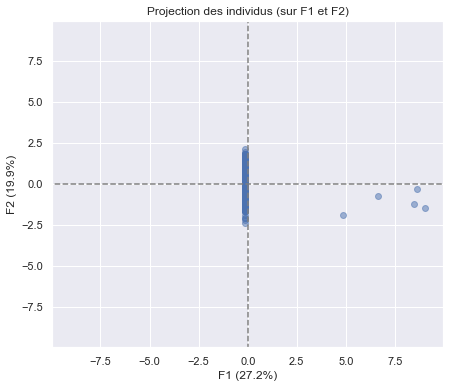

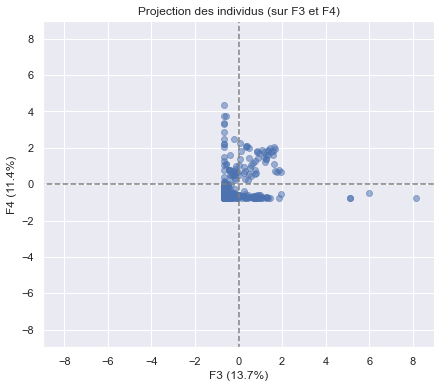

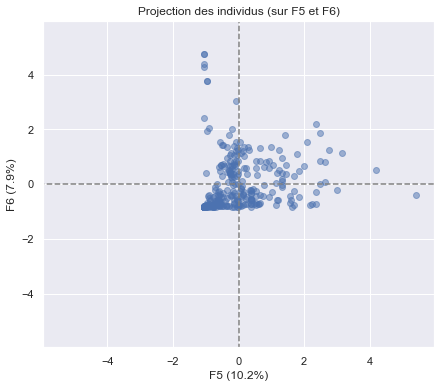

In [12]:
X_ech_index = data.loc[:, cols_acp].sample(300).index
X_ech = data.loc[X_ech_index, cols_acp].values
X_proj_ech = preprocessing.StandardScaler().fit_transform(X_ech)

fonctions_data.display_factorial_planes(X_proj_ech, N_COMP , pca, [(0,1),(2,3),(4,5)], alpha = 0.5)


On observe des points relativement mal projetés. Le phénomène peu s'expliquer de deux manière:

- La présence de valeurs atypiques non négigeable. 
- Des composantes principales qui captent peu d'inertie du nuage de point original

## 6) Clustering (sur la variable 'energy')

**Clusters**

In [80]:
col_qtcont = data.select_dtypes(include=[np.number]).columns.to_list()
df_cluster = data[col_qtcont].dropna()

In [81]:
df_cluster.shape

(56498, 9)

In [82]:
data.shape

(56498, 16)

In [83]:
# Mise à l'échelle

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(df_cluster)
df_cluster_scaled = scaler.transform(df_cluster)

C:\Users\yanni\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\yanni\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\yanni\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\yanni\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\yanni\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_i

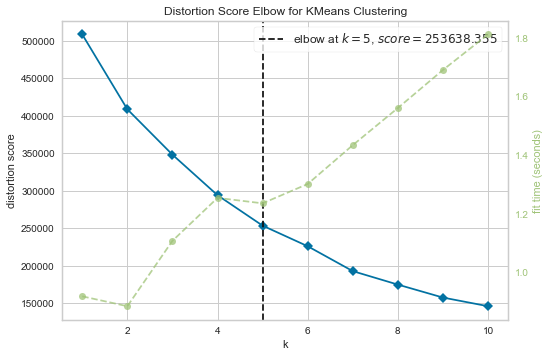

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [84]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 11))

visualizer.fit(df_cluster_scaled)    # Fit the data to the visualizer
# visualizer.poof()    # Draw/show/poof the data
plt.grid(False)
visualizer.show()

Concernant le nombre de clusters, on choisira plutot k=3, car celui-ci présente le meme écart de distorsion de pour k=4.

In [85]:
# Avec k=3 le meilleur hyper-paramètre pour KMeans
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=3)
kmeans = k_means.fit(scaler.transform(df_cluster))
data['cluster'] = kmeans.labels_
data.head()

C:\Users\yanni\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,url,product_name,image_small_url,main_category_fr,categories_tags,organic,energy_100g,nutrition_score_fr_100g,saturated_fat_100g,sugars_100g,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,fiber_100g,nutrition_grade_fr,cluster
0,http://world-fr.openfoodfacts.org/produit/0000...,Salade Cesar,NaN,Légumes frais,"en:plant-based-foods-and-beverages,en:plant-ba...",NaN,0.0,6.0,7.000,0.000,22.00,12.00,23.00,2.160,2.000,C,0
1,http://world-fr.openfoodfacts.org/produit/0000...,Chaussons tressés aux pommes,NaN,Pâtisseries,"en:sugary-snacks,en:biscuits-and-cakes,en:past...",NaN,0.0,9.0,2.000,24.700,3.33,10.70,38.70,0.647,2.000,C,0
2,http://world-fr.openfoodfacts.org/produit/0000...,Pain Burger Artisan,NaN,Boulange,fr:boulange,NaN,0.0,1.0,0.333,1.110,10.00,1.11,53.30,1.520,2.220,B,0
3,http://world-fr.openfoodfacts.org/produit/0000...,Quiche Lorraine,NaN,Plats préparés,"en:meals,en:pizzas-pies-and-quiches,en:quiches...",NaN,0.0,2.0,2.860,0.714,5.36,6.79,7.86,0.499,0.357,B,0
4,http://world-fr.openfoodfacts.org/produit/0000...,Belgische Pralinen,NaN,Aliments et boissons à base de végétaux,"en:plant-based-foods-and-beverages,en:plant-ba...",False,0.0,26.0,21.100,51.500,4.70,33.30,53.80,0.090,0.000,E,2


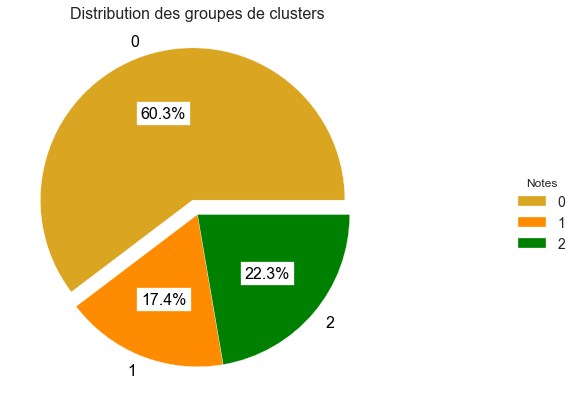

In [86]:
fonctions_data.trace_pieplot(data, 'cluster',
                          'Distribution des groupes de clusters', 'Notes', liste_colors=["goldenrod", "darkorange", "green"])

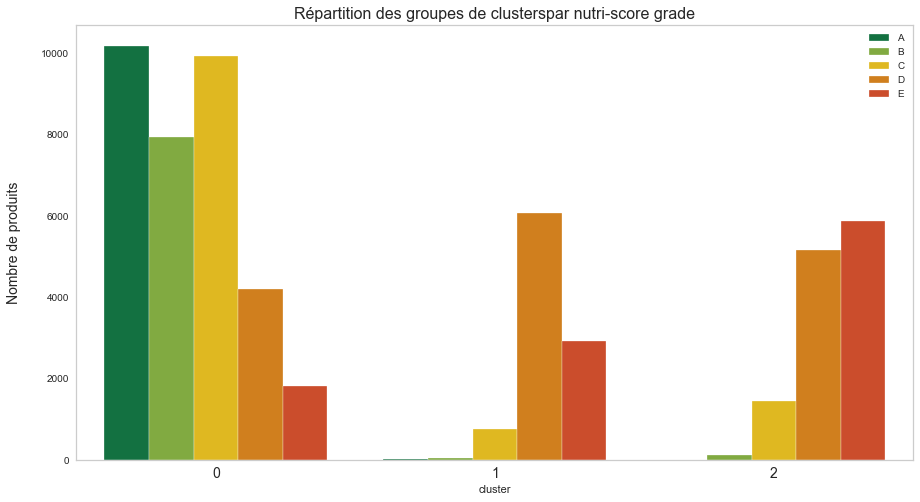

In [87]:
colors_nutri = ['#038141', '#85bb2f', '#fecb02', '#ee8100', '#e63e11']
plt.figure(figsize=(15, 8))
sns.countplot(x='cluster', hue='nutrition_grade_fr', data=data,
              palette=colors_nutri)

plt.legend(loc=1)
plt.ylabel('Nombre de produits', labelpad=20, fontsize=14)
plt.xticks(fontsize=14)
plt.title(
    'Répartition des groupes de clusterspar nutri-score grade', fontsize=16)
plt.grid(False)
plt.show()

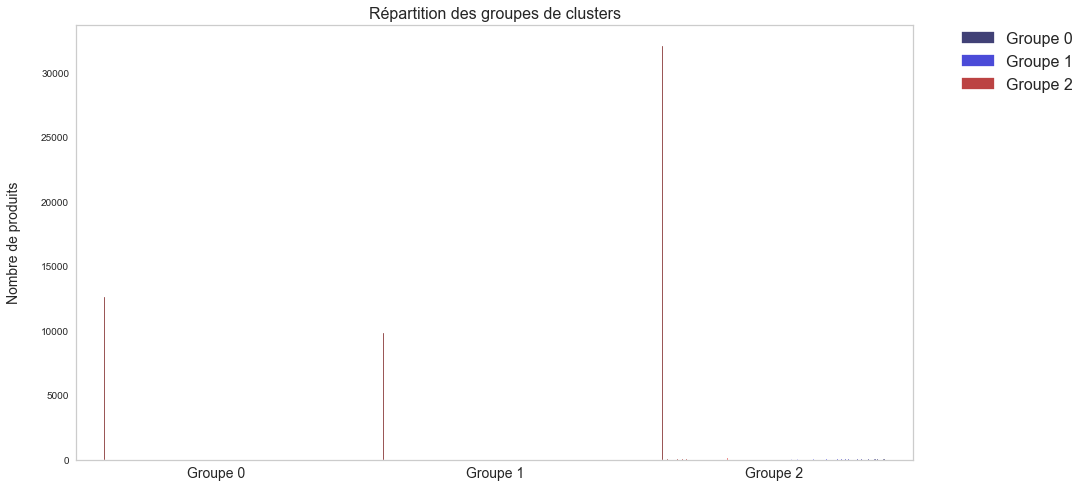

In [88]:
plt.figure(figsize=(15, 8))

sns.countplot(x='cluster', hue='energy_100g', data=data,
              palette='seismic_r', order=[2, 1, 0])

plt.ylabel('Nombre de produits', labelpad=20, fontsize=14)
plt.xticks([0, 1, 2], ['Groupe 0', 'Groupe 1', 'Groupe 2'],
           fontsize=14)
plt.title('Répartition des groupes de clusters', fontsize=16)
#plt.ylim([0, 1000])
plt.xlabel('')
# Légende
label_patches = [mpatches.Patch(color='#414176', label='Groupe 0'),
                 mpatches.Patch(color='#4b4bd8', label='Groupe 1'),
                 mpatches.Patch(color='#bc4343', label='Groupe 2')]
plt.legend(handles=label_patches, bbox_to_anchor=(1.05, 1),
           loc=2, borderaxespad=0., facecolor='white', fontsize=16)

plt.grid(False)
plt.show()

In [93]:
# Gorupe 0
cond0 = data['cluster'] == 0
df0 = data[cond0]['energy_100g']
serie_0 = df0.describe()
# Groupe 1
cond1 = data['cluster'] == 1
df1 = data[cond1]['energy_100g']
serie_1 = df1.describe()
# Groupe 2
cond2 = data['cluster'] == 2
df2 = data[cond2]['energy_100g']
serie_2 = df2.describe()

# Dataframe des statistiques par groupe
liste_cluster = [serie_0.values, serie_1.values, serie_2.values]
cols_cluster = serie_1.index
data_cluster = pd.DataFrame(liste_cluster, columns=cols_cluster, index=[
                            'Groupe 0', 'Groupe 1', 'Groupe 2'])
data_cluster

,count,mean,std,min,25%,50%,75%,max
Groupe 0,34077.0,3.284354,15.522150,0.0,0.0,0.0,0.0,100.0
Groupe 1,9823.0,0.039382,1.478592,0.0,0.0,0.0,0.0,75.0
Groupe 2,12598.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


Les clusters sont classés par groupe d'energie nutritionnelle.

- groupe 0 : energie nutritionnelle moyenne 
- groupe 1 : energie nutritionnelle faible 
- groupe 2 : forte energie nutritionnelle 

C:\Users\yanni\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\yanni\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4



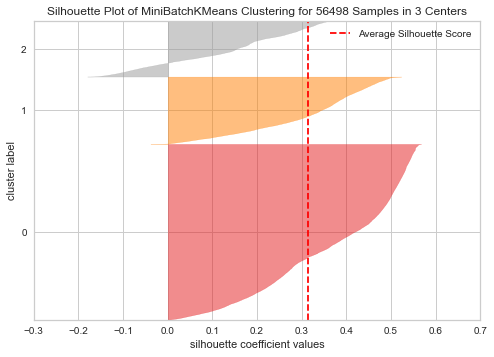

<AxesSubplot:title={'center':'Silhouette Plot of MiniBatchKMeans Clustering for 56498 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [90]:
from sklearn.cluster import MiniBatchKMeans

from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
model = MiniBatchKMeans(3)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(df_cluster_scaled)  # Fit the training data to the visualizer
visualizer.poof()  # Draw/show/poof the data

Le jeu de données contient toutes les données nécessaires à notre idée d'application de moteur de recommandations.

- protéines,
- nutri-score,
- les glucides, lipides, sel, et fibres.

L'application sera dans un premier temps, un moteur de recommandation : à partir de la recherche d'un produit, la liste des produits les plus sains classés par le nombre de g de protéines le plus faible possible sera proposée, après interrogation de la base de données d'Open Food Facts et à nombre de g de protéines équivalent, le produit le plus sain (nutri-score faible) sera retourné.